In [ ]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 451 kB 27.4 MB/s 
     |████████████████████████████████| 5.8 MB 47.4 MB/s 
     |████████████████████████████████| 132 kB 62.0 MB/s 
     |████████████████████████████████| 212 kB 75.4 MB/s 
     |████████████████████████████████| 182 kB 79.1 MB/s 
     |████████████████████████████████| 127 kB 78.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.1 MB/s 


In [ ]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import re
import numpy as np
import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import pandas as pd
from scipy import stats
from sklearn import metrics
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from dataloaders import GoEmotionsSoft

In [ ]:
go_emotions = load_dataset("go_emotions")
data = go_emotions.data

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train, valid, test = data["train"].to_pandas(), data["validation"].to_pandas(), data["test"].to_pandas()

In [ ]:
train_text = train["text"].tolist()
train_labels = train["labels"].tolist()
valid_text = valid["text"].tolist()
valid_labels = valid["labels"].tolist()
test_text = test["text"].tolist()
test_labels = test["labels"].tolist()

In [ ]:
text = train_text+valid_text+test_text
labels = train_labels+valid_labels+test_labels

In [ ]:
text = pd.DataFrame(text)
text.rename({0: 'text'}, axis=1, inplace=True)
labels= pd.DataFrame(labels)
labels.rename({0: 'emotions'}, axis=1, inplace=True)

In [ ]:
text.head()

,text
0,My favourite food is anything I didn't have to...
1,"Now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING
3,To make her feel threatened
4,Dirty Southern Wankers


In [ ]:
labels.head()

,emotions,1,2,3,4
0,27,NaN,NaN,NaN,NaN
1,27,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,14,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN


In [ ]:
labels = labels.drop([1,2,3,4], axis=1)

In [ ]:
data = pd.concat([text, labels], axis=1)

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
mapping = {
    0:"verypositive",
    1:"verypositive",
    2:"verynegative",
    3:"verynegative",
    4:"positive",
    5:"positive",
    6:"other",
    7:"neutral",
    8:"positive",
    9:"verynegative",
    10:"negative",
    11:"verynegative",
    12:"verynegative",
    13:"verypositive",
    14:"verynegative",
    15:"positive",
    16:"verynegative",
    17:"verypositive",
    18:"verypositive",
    19:"negative",
    20:"positive",
    21:"positive",
    22:"other",
    23:"other",
    24:"other",
    25:"negative",
    26:"other",
    27:"neutral",
}
# mapping = {
#     0:"admiration",
#     1:"amusement",
#     2:"anger",
#     3:"annoyance",
#     4:"approval",
#     5:"caring",
#     6:"confusion",
#     7:"curiosity",
#     8:"desire",
#     9:"disappointment",
#     10:"disapproval",
#     11:"disgust",
#     12:"embarrassment",
#     13:"excitement",
#     14:"fear",
#     15:"gratitude",
#     16:"grief",
#     17:"joy",
#     18:"love",
#     19:"nervousness",
#     20:"optimism",
#     21:"pride",
#     22:"realization",
#     23:"relief",
#     24:"remorse",
#     25:"sadness",
#     26:"surprise",
#     27:"neutral",
# }

n_labels = len(mapping)

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3


In [ ]:
emotions=[]
for i in data.emotions:
    emotions.append(mapping[i])
  
data['emotions']=emotions

In [ ]:
data.head()

,text,emotions
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,verynegative
3,To make her feel threatened,verynegative
4,Dirty Southern Wankers,verynegative


In [ ]:
mapping

{0: 'verypositive',
 1: 'verypositive',
 2: 'verynegative',
 3: 'verynegative',
 4: 'positive',
 5: 'positive',
 6: 'other',
 7: 'neutral',
 8: 'positive',
 9: 'verynegative',
 10: 'negative',
 11: 'verynegative',
 12: 'verynegative',
 13: 'verypositive',
 14: 'verynegative',
 15: 'positive',
 16: 'verynegative',
 17: 'verypositive',
 18: 'verypositive',
 19: 'negative',
 20: 'positive',
 21: 'positive',
 22: 'other',
 23: 'other',
 24: 'other',
 25: 'negative',
 26: 'other',
 27: 'neutral'}

In [ ]:
# Balancing Neutral
# temp_df = data[data.emotions=="neutral"]
# temp_df=temp_df.sample(n = 4000)
# data= data[data.emotions!= 'neutral']
# data = pd.concat([data, temp_df])

# from sklearn.utils import shuffle
# data = shuffle(data)
# data = data.reset_index()

# data.head()

In [ ]:
data.emotions.value_counts()

neutral         18231
verypositive    11910
positive         9150
verynegative     7674
other            3982
negative         3316
Name: emotions, dtype: int64

In [ ]:
classes_ = ["verypositive", "positive", "negative", "verynegative", "neutral", "other"]
new_list_text=[]
new_list_emotions=[]

for class_ in classes_:
    temp_df = data[data.emotions==class_]
    if(len(temp_df)>500):
        temp_df=temp_df.sample(n = 3000)
    for i in temp_df.text:
        new_list_text.append(i)
    for i in temp_df.emotions:
        new_list_emotions.append(i)

new_df = pd.DataFrame(list(zip(new_list_text, new_list_emotions)), columns =['text', 'emotions'])  
from sklearn.utils import shuffle
new_df = shuffle(new_df)

data=new_df


In [ ]:
max_len = 0
all_len=[]
for i in data.text:
    all_len.append(len(i))
    max_len=max(max_len,len(i))
print(max_len)    

211


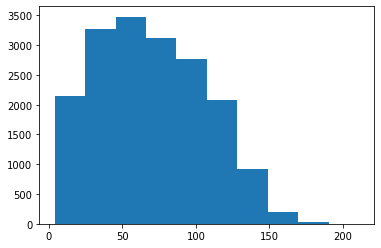

In [ ]:
from matplotlib import pyplot as plt
plt.hist(all_len)
plt.show()

In [ ]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for the dataset
class ConstructVocab():
    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
        
    def create_index(self):
        for s in self.sentences:
            # update with individual tokens
            self.vocab.update(s.split(' '))
            
        # sort the vocab
        self.vocab = sorted(self.vocab)

        # add a padding token with index 0
        self.word2idx['<pad>'] = 0
        
        # word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # +1 because of pad token
        
        # index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word  

In [ ]:
len(data.loc[0].text.split(' '))

25

In [ ]:
len(data)

18000

In [ ]:
data["token_size"] = data["text"].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 200].copy()

In [ ]:
data.head()

,text,emotions,token_size
4561,Thanks for keep us posted,positive,5
3563,"Feel free to PM me, I was a longtime vegetaria...",positive,14
6348,"Man I'm sad, he was my favorite [NAME] when he...",negative,21
17066,> Am i missing something? Because it won't be ...,other,10
11402,WHAT THE FUCK,verynegative,3


In [ ]:
data['token_size'].describe()

count    18000.000000
mean        13.179889
std          6.694809
min          1.000000
25%          8.000000
50%         13.000000
75%         18.000000
max         33.000000
Name: token_size, dtype: float64

In [ ]:
inputs = ConstructVocab(data["text"].values.tolist())

In [ ]:
# vectorize to tensor
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')]  for es in data["text"].values.tolist()]

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# calculate the max_length of input tensor
max_length_inp = max_length(input_tensor)
print(max_length_inp)

33


In [ ]:
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)
    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x
    return padded

In [ ]:
# inplace padding
input_tensor = [pad_sequences(x, max_length_inp) for x in input_tensor]

In [ ]:
input_tensor[0:2]

[array([ 7811, 16369, 19326, 29536, 23437,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]),
 array([ 3910, 16512, 28551,  6288, 20579,  4669, 29984,  8851, 20105,
        29660, 10604, 28792, 28551, 29652,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0])]

In [ ]:
### convert targets to one-hot encoding vectors
emotions = list(set(data.emotions.unique()))
num_emotions = len(emotions)
# binarizer
mlb = preprocessing.MultiLabelBinarizer()
data_labels =  [set(emos) & set(emotions) for emos in data[['emotions']].values]
bin_emotions = mlb.fit_transform(data_labels)
target_tensor = np.array(bin_emotions.tolist())

In [ ]:
target_tensor[0:2] 

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [ ]:
data[0:2]

,text,emotions,token_size
4561,Thanks for keep us posted,positive,5
3563,"Feel free to PM me, I was a longtime vegetaria...",positive,14


In [ ]:
get_emotion = lambda t: np.argmax(t)

In [ ]:
get_emotion(target_tensor[0])

3

In [ ]:
emotion_dict=mapping
emotion_dict[get_emotion(target_tensor[0])]

'verynegative'

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(input_tensor_train[0].dtype)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_val, target_tensor_val, test_size=0.5)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test)

int64


(14400, 14400, 1800, 1800, 1800, 1800)

In [ ]:
TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)
BATCH_SIZE = 64
TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
# target_size = num_emotions
target_size = len(data.emotions.unique())
n_labels = target_size
target_size

6

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
# convert the data to tensors and pass to the Dataloader 
# to create an batch iterator

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

In [ ]:
train_logits = torch.zeros((50000, n_labels))

train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
val_dataset = MyData(input_tensor_val, target_tensor_val)
test_dataset = MyData(input_tensor_test, target_tensor_test)

print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

In [ ]:
val_loader.batch_size

64

In [ ]:
class EmoGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(EmoGRU, self).__init__()
        self.batch_sz = batch_sz
        self.hidden_units = hidden_units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_size = output_size
        
        # layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
    
    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch_sz, self.hidden_units)).to(device)
    
    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden) # max_len X batch_size X hidden_units
        out = output[-1, :, :] 
        out = self.dropout(out)
        out = self.fc(out)
        return out, self.hidden  

In [ ]:
### sort batch function to be able to use with pad_packed_sequence
def sort_batch(X, y, lengths, logits):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    logits = logits[indx]
    return X.transpose(0,1), y, lengths, logits # transpose (batch x seq) to (seq x batch)

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
# model.to(device)

# # obtain one sample from the data iterator
# it = iter(train_dataset)
# x, y, x_len, logits = next(it)

# # sort the batch first to be able to use with pac_pack sequence
# xs, ys, lens, logits = sort_batch(x, y, x_len, logits)

# print("Input size: ", xs.size())

# output, _ = model(xs.to(device), lens, device)
# print(output.size())

In [ ]:
options = {
    "epochs": 20,
    "arch": "EmoGRU",
    "k": 5,
    "gamma": 0.9,
    "t": 10
}

In [ ]:
class KL(nn.Module):
    def __init__(self, T):
        super(KL, self).__init__()
        self.T = T

    def forward(self, y_s, p_t):
        p_s = nn.functional.log_softmax(y_s/self.T, dim=1)
        loss = nn.functional.kl_div(p_s, p_t, size_average=False) * (self.T**2) / p_s.shape[0]
        return loss

    
class Temperture_Softmax(nn.Module):
    def __init__(self, T):
        super(Temperture_Softmax, self).__init__()
        self.T = T

    def forward(self, y):    
        p = nn.functional.softmax(y/self.T, dim=1)
        return p

In [ ]:
### Enabling cuda
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

### loss criterion and optimizer for training
criterion = nn.CrossEntropyLoss() # the same as log_softmax + NLLLoss

criterion_cls = nn.CrossEntropyLoss()    


criterion_soft = Temperture_Softmax(options["t"])

criterion_kl = KL(options["t"])
criterion_list = nn.ModuleList([])
criterion_list.append(criterion_cls)    # classification loss
criterion_list.append(criterion_soft)    # KL divergence loss, original knowledge distillation
criterion_list.append(criterion_kl)


optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    """ CrossEntropyLoss expects outputs and class indices as target """
    # convert from one-hot encoding to class indices
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target) 
    return loss   #TODO: refer the parameter of these functions as the same
    
def accuracy(target, logit):
    ''' Obtain accuracy for training round '''
    target = torch.max(target, 1)[1] # convert from one-hot encoding to class indices
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100.0 * corrects / len(logit)
    return accuracy

In [ ]:
def train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits):
    model.train()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()
    
    for idx, (image, labels, lens, softlabel, index) in enumerate(train_loader):
        if torch.cuda.is_available():
            image = image.cuda()
            labels = labels.cuda()
        output, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = output
        loss = criterion(output, labels.argmax(dim=1))
        acc1 = accuracy(output, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1.item(), image.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return top1.avg, losses.avg, train_logits




def train_lwr(epoch, train_loader, model, criterion_list, optimizer, options, train_logits):
    model.train()
    if torch.cuda.is_available():
        train_logits=train_logits.cuda()

    criterion_cls = criterion_list[0]
    critetion_soft = criterion_list[1]
    criterion_kl = criterion_list[2]

    losses = AverageMeter()
    top1 = AverageMeter()

    
    for idx, data in enumerate(train_loader):
        image, labels, lens, logits, index = data
        if torch.cuda.is_available():
            image = image.cuda().int()
            labels = labels.cuda()
            logits = logits.cuda()
        
        soft_label = critetion_soft(logits)        
        preact = False
        logit_s, _ = model(image.permute(1 ,0).to(device), lens, device)
        train_logits[index] = logit_s
        loss_cls = criterion_cls(logit_s, labels.argmax(dim=1))        
        loss_kl = criterion_kl(logit_s, soft_label)

        if epoch<=options["k"]:
            loss = loss_cls 
        else:
            num_5 = int(epoch/options["k"])
            cure = num_5*options["k"]
            
            loss = (options["gamma"]+(1-cure/240)*(1-options["gamma"])) * loss_cls + cure/240*(1-options["gamma"])* loss_kl

        acc1 = accuracy(logit_s, labels)
        losses.update(loss.item(), image.size(0))
        top1.update(acc1.item(), image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return top1.avg, losses.avg, train_logits

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def validate(val_loader, model, criterion, options):
    
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    with torch.no_grad():
        
        for idx, (image, label, lens) in enumerate(val_loader):

            if torch.cuda.is_available():
                image = image.cuda()
                labels = label.cuda()

            output, _ = model(image.permute(1 ,0).to(device), lens, device)
            loss = criterion(output, labels.argmax(dim=1))
            acc1 = accuracy(output, labels)
            losses.update(loss.item(), image.size(0))
            top1.update(acc1.item(), image.size(0))
            
    return top1.avg,losses.avg


# Cross Entropy

In [ ]:
# No LWR

train_accs = []
train_losses = []
test_accs = []
test_losses = []

best_acc = 0
for epoch in range(1, int(options["epochs"])+ 1):

        train_acc, train_loss, train_logits= train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits)
         
        
        train_logits = train_logits.detach().cpu()
            
        if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                                drop_last=True,
                                shuffle=True)
        
        print('epoch {}'.format(epoch))


        test_acc, test_loss = validate(val_loader, model, criterion, options)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        print("Current Test Accuracy:",test_acc)
        # calculate best accuracy.
        if test_acc > best_acc:
            best_acc = test_acc
        
        print('best accuracy:', best_acc)


epoch 1
Current Test Accuracy: 33.426339285714285
best accuracy: 33.426339285714285
epoch 2
Current Test Accuracy: 41.015625
best accuracy: 41.015625
epoch 3
Current Test Accuracy: 43.638392857142854
best accuracy: 43.638392857142854
epoch 4
Current Test Accuracy: 43.917410714285715
best accuracy: 43.917410714285715
label update
epoch 5
Current Test Accuracy: 42.52232142857143
best accuracy: 43.917410714285715
epoch 6
Current Test Accuracy: 43.359375
best accuracy: 43.917410714285715
epoch 7
Current Test Accuracy: 42.857142857142854
best accuracy: 43.917410714285715
epoch 8
Current Test Accuracy: 44.029017857142854
best accuracy: 44.029017857142854
epoch 9
Current Test Accuracy: 42.075892857142854
best accuracy: 44.029017857142854
label update
epoch 10
Current Test Accuracy: 43.30357142857143
best accuracy: 44.029017857142854
epoch 11
Current Test Accuracy: 41.85267857142857
best accuracy: 44.029017857142854
epoch 12
Current Test Accuracy: 43.080357142857146
best accuracy: 44.029017857

In [ ]:
print('train_accs', train_accs)
print('train_losses', train_losses)
print('test_accs', test_accs)
print('test_losses', test_losses)

train_accs [22.319444444444443, 41.451388888888886, 56.479166666666664, 73.64583333333333, 89.95833333333333, 96.85416666666667, 98.13888888888889, 98.19444444444444, 98.60416666666667, 98.86805555555556, 98.66666666666667, 98.45138888888889, 98.76388888888889, 99.18055555555556, 99.09027777777777, 98.85416666666667, 98.79166666666667, 98.94444444444444, 99.19444444444444, 99.34027777777777]
train_losses [1.7976485543780856, 1.484982958899604, 1.1654239201545715, 0.739176501168145, 0.29851991097132363, 0.10168674915201134, 0.06041132537648082, 0.0555196672760778, 0.0458009802757038, 0.03684600700158626, 0.04342976609555384, 0.0469121742936679, 0.039439637860179774, 0.027226358636851525, 0.0280309852404106, 0.035301508949293445, 0.03900419975165278, 0.03242194430501614, 0.02493165437791807, 0.023727463095047925]
test_accs [33.426339285714285, 41.015625, 43.638392857142854, 43.917410714285715, 42.52232142857143, 43.359375, 42.857142857142854, 44.029017857142854, 42.075892857142854, 43.30

## Validation

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    batch_loss = criterion(predictions, targ.to(device).argmax(dim=1))     
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)
print("Test Loss: ", batch_loss.cpu().detach().numpy())


Test Accuracy:  41.238839285714285
Test Loss:  5.239914


# LWR

In [ ]:
model = EmoGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

train_accs = []
train_losses = []
test_accs = []
test_losses = []

best_acc = 0
for epoch in range(1, int(options["epochs"])+ 1):

        if epoch<=options["k"]:
            train_acc, train_loss, train_logits= train_normal(epoch, train_loader, model, criterion, optimizer, options, train_logits)
        else:
            train_acc, train_loss, train_logits= train_lwr(epoch, train_loader, model, criterion_list, optimizer, options, train_logits)
         
        
        train_logits = train_logits.detach().cpu()
            
        if epoch>=options["k"] and epoch%options["k"]==0:
            print('label update')
            train_dataset = GoEmotionsSoft(input_tensor_train, target_tensor_train, train_logits)
            train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                                drop_last=True,
                                shuffle=True)
        
        print('epoch {}'.format(epoch))

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        test_acc, test_loss = validate(val_loader, model, criterion, options)

        print("Current Test Accuracy:",test_acc)
        # calculate best accuracy.
        if test_acc > best_acc:
            best_acc = test_acc
        
        print('best accuracy:', best_acc)


epoch 1
Current Test Accuracy: 34.877232142857146
best accuracy: 34.877232142857146
epoch 2
Current Test Accuracy: 41.964285714285715
best accuracy: 41.964285714285715
epoch 3
Current Test Accuracy: 43.917410714285715
best accuracy: 43.917410714285715
epoch 4
Current Test Accuracy: 43.69419642857143
best accuracy: 43.917410714285715
label update
epoch 5
Current Test Accuracy: 43.247767857142854
best accuracy: 43.917410714285715


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 6
Current Test Accuracy: 44.140625
best accuracy: 44.140625
epoch 7
Current Test Accuracy: 42.689732142857146
best accuracy: 44.140625
epoch 8
Current Test Accuracy: 43.973214285714285
best accuracy: 44.140625
epoch 9
Current Test Accuracy: 42.354910714285715
best accuracy: 44.140625
label update
epoch 10
Current Test Accuracy: 42.354910714285715
best accuracy: 44.140625
epoch 11
Current Test Accuracy: 41.85267857142857
best accuracy: 44.140625
epoch 12
Current Test Accuracy: 41.238839285714285
best accuracy: 44.140625
epoch 13
Current Test Accuracy: 42.745535714285715
best accuracy: 44.140625
epoch 14
Current Test Accuracy: 40.848214285714285
best accuracy: 44.140625
label update
epoch 15
Current Test Accuracy: 42.689732142857146
best accuracy: 44.140625
epoch 16
Current Test Accuracy: 41.908482142857146
best accuracy: 44.140625
epoch 17
Current Test Accuracy: 42.410714285714285
best accuracy: 44.140625
epoch 18
Current Test Accuracy: 42.96875
best accuracy: 44.140625
epoch 19
C

In [ ]:
print('train_accs', train_accs)
print('train_losses', train_losses)
print('test_accs', test_accs)
print('test_losses', test_losses)

train_accs [23.083333333333332, 41.90277777777778, 56.55555555555556, 73.52083333333333, 89.55555555555556, 96.32638888888889, 98.46527777777777, 98.92361111111111, 98.98611111111111, 98.73611111111111, 98.93055555555556, 98.57638888888889, 98.24305555555556, 98.98611111111111, 99.27777777777777, 99.51388888888889, 99.66666666666667, 99.30555555555556, 99.02083333333333, 99.125]
train_losses [1.7849067979388766, 1.4767313268449571, 1.1600022803412544, 0.7441945065392388, 0.31652359392907886, 0.11822479214933183, 0.05588350878407558, 0.044433142766356466, 0.042382628963225415, 0.05563346832990646, 0.04133403826504946, 0.054706398186584314, 0.05947613961994648, 0.04027119826939371, 0.0358371191057894, 0.026613739083210627, 0.02202748961539732, 0.032499697167012426, 0.045959214265975684, 0.04362131569948461]
test_accs [40.792410714285715, 34.877232142857146, 41.964285714285715, 43.917410714285715, 43.69419642857143, 43.247767857142854, 44.140625, 42.689732142857146, 43.973214285714285, 42

## Validation

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    batch_loss = criterion(predictions, targ.to(device).argmax(dim=1))     
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)
print("Test Loss: ", batch_loss.cpu().detach().numpy())


Test Accuracy:  41.629464285714285
Test Loss:  3.6915243


In [ ]:
model.parameters

<bound method Module.parameters of EmoGRU(
  (embedding): Embedding(31340, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (gru): GRU(256, 1024)
  (fc): Linear(in_features=1024, out_features=6, bias=True)
)>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# model.load_state_dict(torch.load("/content/model.pth"))
# model.eval()

In [ ]:
test_accuracy = 0
all_predictions = []
x_raw = []
y_raw = []

device = "cuda" # we don't need GPU to do testing
model.to(device)
# model.to("cpu")

for (batch, (inp, targ, lens)) in enumerate(test_loader):          
    predictions,_ = model(inp.permute(1, 0).to(device), lens, device)        
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy
    
    x_raw = x_raw + [x for x in inp]
    y_raw = y_raw + [y for y in targ]
    
    all_predictions.append(predictions)
    
print("Test Accuracy: ", test_accuracy.cpu().detach().numpy() / TEST_N_BATCH)

Test Accuracy:  41.74107142857143


In [ ]:
torch.save(model.state_dict(), "/content/model.pth")